In [ ]:
from google.colab import userdata

github_token = userdata.get("GITHUB_TOKEN")

# Install the private repository using the token
! pip install nnsight -q
!pip install --upgrade git+https://{github_token}@github.com/withmartian/TinySQL.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 4.3 MB/s eta 0:00:00
  Cloning https://****@github.com/withmartian/TinySQL.git to /tmp/pip-req-build-7skk7t40
  Running command git clone --filter=blob:none --quiet 'https://****@github.com/withmartian/TinySQL.git' /tmp/pip-req-build-7skk7t40
  Resolved https://****@github.com/withmartian/TinySQL.git to commit a8661cb4d84766da034b22c797a454e5f58c5642
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for TinySQL: filename=TinySQL-1.0-py3-none-any.whl size=44158 sha256=ee6c65c2e79872d91a189b7358e67c1e632b9ffd72265b5ba95b8f53be39b37d
  Stored in directory: /tmp/pip-ephem-wheel-cache-_h6918iz/wheels/a9/72/1c/ba39c57a9acd2e1efd9554f1a2ed8d8987923fbad44ab80971
Successfully built TinyS

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from TinySQL.load_data.load_model import load_tinysql_model

device = torch.device('cuda')

tokenizer_sql = AutoTokenizer.from_pretrained('withmartian/sql_interp_bm1_cs1_experiment_1.8')
tokenizer_sql.pad_token = tokenizer_sql.eos_token

model_sql = AutoModelForCausalLM.from_pretrained(
    'withmartian/sql_interp_bm1_cs1_experiment_1.8',
    pad_token_id=tokenizer_sql.eos_token_id
)
model_sql.config.pad_token_id = tokenizer_sql.pad_token_id
model_sql.to(device)

tokenizer_config.json:   0%|          | 0.00/883 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/315M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50258, 1024)
    (wpe): Embedding(2048, 1024)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-1): 2 x GPTNeoBlock(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=False)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
          (c_proj): L

## BM1 CS1: **DefCreateTable**, **EngFieldStart**, **EngFieldSeparator**, **DefFieldSeparator** features

In [52]:
def is_in_tiny_stories_vocab(word, tokenizer):
    word = word.lower()

    tokens = tokenizer.encode(word, add_special_tokens=False)

    return len(tokens) == 1

words_ts = [
           "select", "show", "pick", "find",
           "pull", "grab", "take", "move", "walk",
           "run", "jump", "stop", "sing", "fly"
       ]

for word in words_ts:
  print(is_in_tiny_stories_vocab(word, tokenizer_sql))

True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [ ]:
import matplotlib.pyplot as plt
from TinySQL.corrupt_data.clean_corrupt_data import CorruptFeatureTestGenerator

class SimpleSimilarityTester(CorruptFeatureTestGenerator):
   def __init__(self, generate_fn, corruption='EngFieldStart', *args, **kwargs):
       super().__init__(*args, **kwargs)
       self.generate = generate_fn
       self.test_words = [
           "select", "show", "pick", "find",
           "pull", "grab", "take", "move", "walk",
           "run", "jump", "stop", "sing", "fly", 'create'
       ]
       self.test_separators = [
           ",", ";", "&", "|", ":",
           "#", "@", "$", "^", "~",
           "+", "->", "=>", "--", "//", 'and'
       ]
       self.corruption = corruption
   def test_breakdown(self):
       base_item = self._make_base_item()
       base_prompt = base_item.get_alpaca_prompt().replace("show me", "select")
       base_output = self.generate(base_prompt).split()
       results = []

       if self.corruption == 'EngFieldStart':
          print('corrupting EngFieldStart')

          word_similarities = [(word, self.compute_similarity("select", word))
                            for word in self.test_words]
          word_similarities.sort(key=lambda x: x[1])
          for word, similarity in word_similarities:
              corrupted_prompt = base_prompt.replace("select", word)
              corrupt_output = self.generate(corrupted_prompt).split()

              output_similarities = []
              for w1, w2 in zip(base_output, corrupt_output):
                  if w1 == w2:
                      output_similarities.append(1.0)
                  else:
                      output_similarities.append(self.compute_similarity(w1, w2))

              avg_output_similarity = sum(output_similarities) / len(output_similarities) if output_similarities else 0
              results.append((word, avg_output_similarity))


       if self.corruption == 'DefCreateTable':
          print('corrupting DefCreateTable')

          word_similarities = [(word, self.compute_similarity("create", word))
                            for word in self.test_words]
          word_similarities.sort(key=lambda x: x[1])

          for word, similarity in word_similarities:
              corrupted_prompt = base_prompt.replace("CREATE", word.upper())
              corrupt_output = self.generate(corrupted_prompt).split()

              output_similarities = []
              for w1, w2 in zip(base_output, corrupt_output):
                  if w1 == w2:
                      output_similarities.append(1.0)
                  else:
                      output_similarities.append(self.compute_similarity(w1, w2))
              avg_output_similarity = sum(output_similarities) / len(output_similarities) if output_similarities else 0
              results.append((word, avg_output_similarity))

       if self.corruption == 'EngFieldSeparator':
          print('corrupting EngFieldSeparator')

          word_similarities = [(word, self.compute_similarity("and", word))
                            for word in self.test_separators]
          word_similarities.sort(key=lambda x: x[1])
          for word, similarity in word_similarities:
              corrupted_prompt = base_prompt.replace("and", word)
              corrupt_output = self.generate(corrupted_prompt).split()
              output_similarities = []
              for w1, w2 in zip(base_output, corrupt_output):
                  if w1 == w2:
                      output_similarities.append(1.0)
                  else:
                      output_similarities.append(self.compute_similarity(w1, w2))

              avg_output_similarity = sum(output_similarities) / len(output_similarities) if output_similarities else 0
              results.append((word, avg_output_similarity))


       if self.corruption == 'DefFieldSeparator':
          print('corrupting DefFieldSeparator')
          word_similarities = [(word, self.compute_similarity(",", word))
                            for word in self.test_separators]
          word_similarities.sort(key=lambda x: x[1])
          for word, similarity in word_similarities:
              corrupted_prompt = base_prompt.replace(",", word)
              corrupt_output = self.generate(corrupted_prompt).split()

              output_similarities = []
              for w1, w2 in zip(base_output, corrupt_output):
                  if w1 == w2:
                      output_similarities.append(1.0)
                  else:
                      output_similarities.append(self.compute_similarity(w1, w2))

              avg_output_similarity = sum(output_similarities) / len(output_similarities) if output_similarities else 0
              results.append((word, avg_output_similarity))



       self.plot_results(results, word_similarities)
       return results

   def compute_similarity(self, str1: str, str2: str) -> float:
       inputs1 = tokenizer_sql(str1, return_tensors='pt', padding=True).to(model_sql.device)
       inputs2 = tokenizer_sql(str2, return_tensors='pt', padding=True).to(model_sql.device)

       with torch.no_grad():
           embeddings1 = model_sql.transformer(inputs1.input_ids).last_hidden_state.mean(dim=1)
           embeddings2 = model_sql.transformer(inputs2.input_ids).last_hidden_state.mean(dim=1)

       similarity = torch.cosine_similarity(embeddings1, embeddings2)
       return similarity.item()

   def plot_results(self, results, word_similarities):
       output_color = "#8ECAE6"  # Soft blue
       input_color = "#A06CD5"   # Medium purple


       sorted_results = [(w, out_sim) for (w, _), (_, out_sim)
                        in sorted(zip(word_similarities, results),
                                key=lambda x: x[0][1], reverse=True)]

       words, output_sims = zip(*sorted_results)
       input_sims = [sim for _, sim in sorted(word_similarities,
                                            key=lambda x: x[1],
                                            reverse=True)]

       plt.figure(figsize=(12, 6))
       plt.plot(range(len(words)), output_sims, color=output_color, ls='-', marker='o', label='Output Similarity')
       plt.plot(range(len(words)), input_sims, color=input_color, ls='--', marker='s', label='Input Similarity')
       plt.xticks(range(len(words)), words, rotation=45)

       for i, (out_sim, in_sim) in enumerate(zip(output_sims, input_sims)):
           plt.text(i, out_sim, f'{out_sim:.3f}', ha='center', va='bottom', color=output_color)
           plt.text(i, in_sim, f'{in_sim:.3f}', ha='center', va='bottom', color=input_color)

       plt.xlabel(f'{self.corruption} (Ordered by Input Similarity)')
       plt.ylabel('Similarity Score')
       plt.title(f'Model Sensitivity to {self.corruption} Substitution')
       plt.legend()
       plt.grid(True, alpha=0.3)
       plt.tight_layout()
       plt.savefig(f'{self.corruption}_breakdown.png', dpi=300)
       plt.show()

def generate_wrapper(prompt):
   inputs = tokenizer_sql(prompt, return_tensors='pt', padding=True).to(model_sql.device)
   outputs = model_sql.generate(
       inputs.input_ids,
       attention_mask=inputs.attention_mask,
       max_new_tokens=100,
       pad_token_id=tokenizer_sql.eos_token_id,
       do_sample=False
   )
   return tokenizer_sql.decode(outputs[0], skip_special_tokens=True)



corrupting DefCreateTable


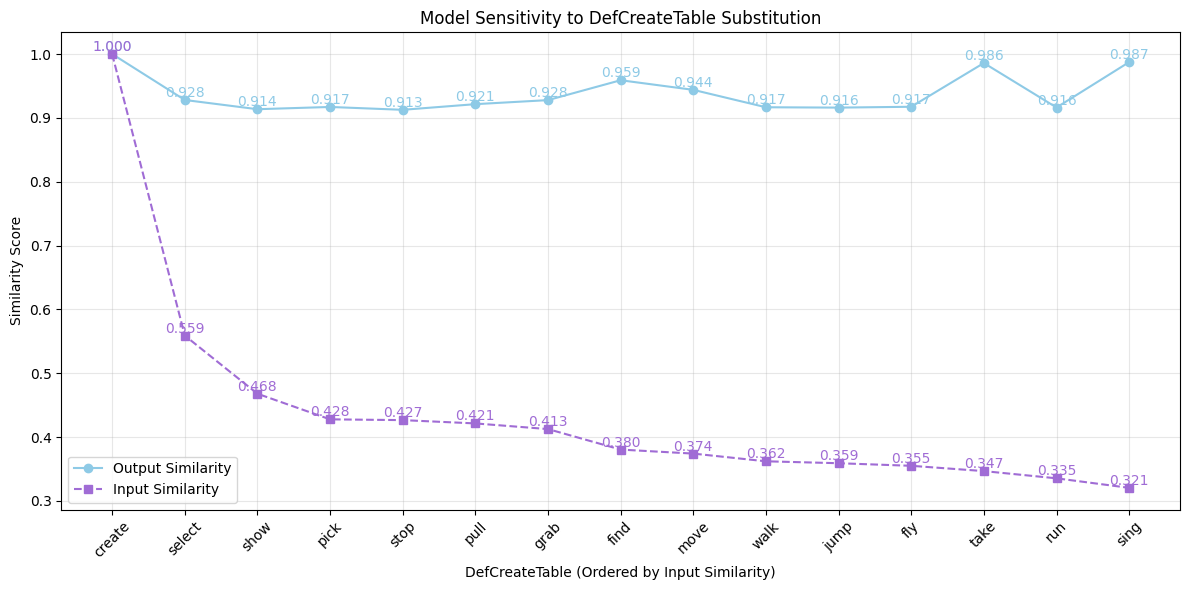

In [ ]:
tester = SimpleSimilarityTester(generate_wrapper, "DefCreateTable")
results = tester.test_breakdown()

corrupting EngFieldStart


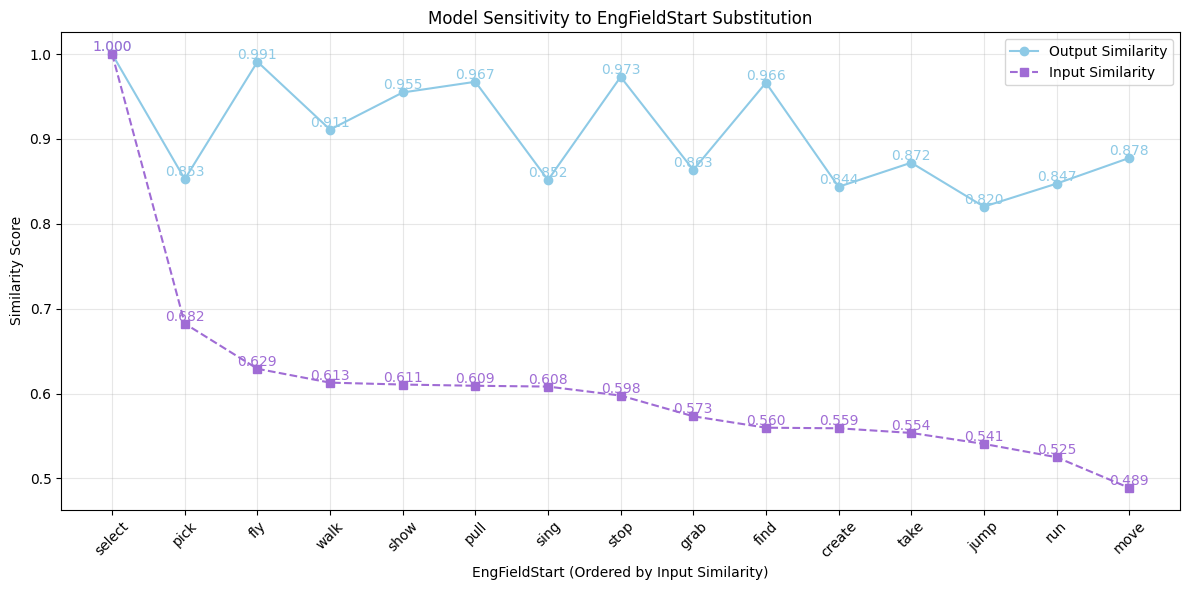

In [ ]:
tester = SimpleSimilarityTester(generate_wrapper, "EngFieldStart")
results = tester.test_breakdown()

corrupting EngFieldSeparator


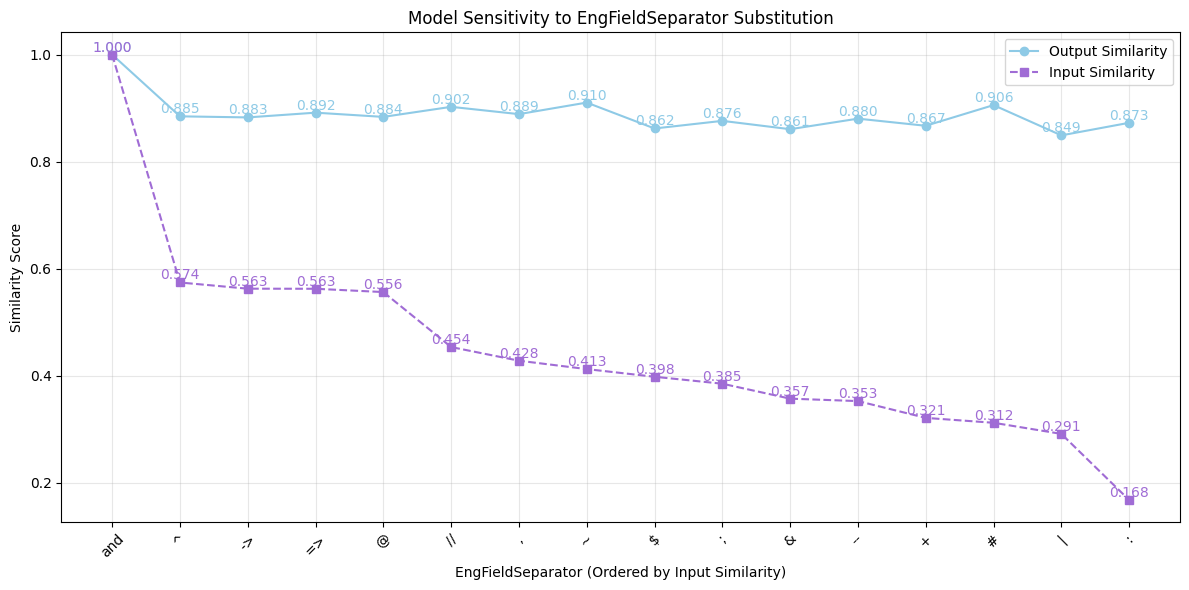

In [ ]:
tester = SimpleSimilarityTester(generate_wrapper, "EngFieldSeparator")
results = tester.test_breakdown()

corrupting DefFieldSeparator


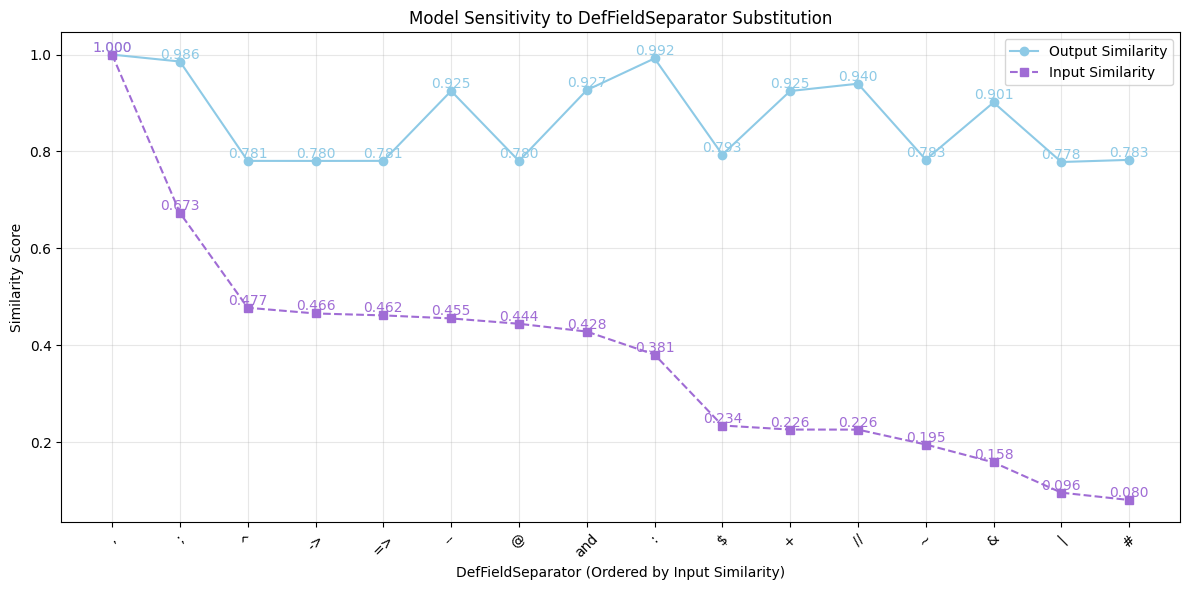

In [ ]:
tester = SimpleSimilarityTester(generate_wrapper, "DefFieldSeparator")
results = tester.test_breakdown()

## BM1 CS1 Duplicate Tokens

### Some functions

In [ ]:
from TinySQL.corrupt_data.clean_corrupt_data import CorruptFeatureTestGenerator as cpt
import random
random.seed(42)
def generate_output(prompt, model, tokenizer):
    inputs = tokenizer(
        prompt,
        return_tensors='pt',
        padding=True,
        truncation=True,
        return_attention_mask=True
    ).to(model.device)

    outputs = model.generate(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        pad_token_id=tokenizer.eos_token_id
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [ ]:
base_item = cpt(1)._make_base_item()
base_prompt = base_item.get_alpaca_prompt()
base_output = generate_output(base_prompt, model_sql, tokenizer_sql)
base_output

'### Instruction: show me the price and amount from the cost table ### Context: CREATE TABLE cost ( price CHAR, amount CHAR ) ### Response: SELECT price, amount FROM cost'

In [ ]:
import re

def swap_field_table_eng_1field(sql_text):
    instruction_text = re.search(r'### Instruction:(.*?)### Context:', sql_text, re.DOTALL)
    instruction = instruction_text.group(1).strip()

    # Simplified table pattern
    table_pattern = r'from the (\w+)'
    table_match = re.search(table_pattern, instruction.lower())
    table_name = table_match.group(1) if table_match else None

    # Simplified field pattern to match "show me the X" format
    fields_pattern = r'show me the (\w+)'
    field_match = re.search(fields_pattern, instruction.lower())
    first_field = field_match.group(1) if field_match else None

    new_text = sql_text.replace(first_field, "TEMP", 1)
    new_text = new_text.replace(table_name, first_field, 1)
    new_text = new_text.replace("TEMP", table_name, 1)

    return new_text

def swap_field_table_eng_2field(sql_text):
    instruction_text = re.search(r'### Instruction:(.*?)### Context:', sql_text, re.DOTALL)
    instruction = instruction_text.group(1).strip()

    # Simplified table pattern
    table_pattern = r'from the (\w+)'
    table_match = re.search(table_pattern, instruction.lower())
    table_name = table_match.group(1) if table_match else None

    # Modified to catch the second field after "and"
    fields_pattern = r'and (\w+)'
    field_match = re.search(fields_pattern, instruction.lower())
    second_field = field_match.group(1) if field_match else None

    new_text = sql_text.replace(second_field, "TEMP", 1)
    new_text = new_text.replace(table_name, second_field, 1)
    new_text = new_text.replace("TEMP", table_name, 1)

    return new_text

def swap_field_table_create_1field(sql_text):
    sections = re.search(r'### Context:(.*?)### Response:', sql_text, re.DOTALL)
    if not sections:
        return sql_text

    context_section = sections.group(1)

    # Simplified CREATE TABLE pattern
    table_pattern = r'CREATE TABLE (\w+)'
    table_match = re.search(table_pattern, context_section)
    table_name = table_match.group(1) if table_match else None

    # Simplified first field pattern
    field_pattern = r'\(\s*(\w+)'
    field_match = re.search(field_pattern, context_section)
    first_field = field_match.group(1) if field_match else None

    if table_name and first_field:
        temp_context = context_section.replace(first_field, "TEMP", 1)
        temp_context = temp_context.replace(table_name, first_field, 1)
        new_context = temp_context.replace("TEMP", table_name, 1)

        before_context = sql_text.split("### Context:")[0]
        after_context = sql_text.split("### Response:")[1]

        return before_context + "### Context:" + new_context + "### Response:" + after_context

    return sql_text

def swap_field_table_create_2field(sql_text):
    sections = re.search(r'### Context:(.*?)### Response:', sql_text, re.DOTALL)
    if not sections:
        return sql_text

    context_section = sections.group(1)

    # Simplified CREATE TABLE pattern
    table_pattern = r'CREATE TABLE (\w+)'
    table_match = re.search(table_pattern, context_section)
    table_name = table_match.group(1) if table_match else None

    # Simplified second field pattern
    field_pattern = r',\s*(\w+)'
    field_match = re.search(field_pattern, context_section)
    second_field = field_match.group(1) if field_match else None

    if table_name and second_field:
        temp_context = context_section.replace(second_field, "TEMP", 1)
        temp_context = temp_context.replace(table_name, second_field, 1)
        new_context = temp_context.replace("TEMP", table_name, 1)

        before_context = sql_text.split("### Context:")[0]
        after_context = sql_text.split("### Response:")[1]

        return before_context + "### Context:" + new_context + "### Response:" + after_context

    return sql_text

def similarity(base_output, corrupt_output):

  def _compute_similarity(str1, str2):
    inputs1 = tokenizer_sql(str1, return_tensors='pt', padding=True).to(model_sql.device)
    inputs2 = tokenizer_sql(str2, return_tensors='pt', padding=True).to(model_sql.device)

    with torch.no_grad():
        embeddings1 = model_sql.transformer(inputs1.input_ids).last_hidden_state.mean(dim=1)
        embeddings2 = model_sql.transformer(inputs2.input_ids).last_hidden_state.mean(dim=1)

    similarity = torch.cosine_similarity(embeddings1, embeddings2)
    return similarity.item()

  output_similarities = []
  for w1, w2 in zip(base_output, corrupt_output):
      if w1 == w2:
          output_similarities.append(1.0)
      else:
          output_similarities.append(_compute_similarity(w1, w2))

  avg_output_similarity = sum(output_similarities) / len(output_similarities) if output_similarities else 0

  return avg_output_similarity


In [ ]:
import re

def extract_all_elements(text):
    result = {
        'instruction': {'table': None, 'fields': (None, None)},
        'context': {'table': None, 'fields': [None, None]},
        'response': {'table': None, 'fields': (None, None)}
    }

    try:
        # Extract from instruction
        instruction_table_pattern = r'from the (\w+) table'
        instruction_fields_pattern = r'show me the (\w+) and (\w+) from'

        instruction_table_match = re.search(instruction_table_pattern, text)
        if instruction_table_match:
            result['instruction']['table'] = instruction_table_match.group(1)

        instruction_fields_match = re.search(instruction_fields_pattern, text)
        if instruction_fields_match:
            result['instruction']['fields'] = instruction_fields_match.groups()
    except Exception as e:
        print(f"Error in instruction extraction: {e}")

    try:
        # Extract from context CREATE TABLE
        context_pattern = r'CREATE TABLE\s+(\w+)\s*\(\s*\n*\s*(\w+)\s+\w+,\s*\n*\s*(\w+)\s+\w+\s*\n*\s*\)'
        context_match = re.search(context_pattern, text)
        if context_match:
            result['context']['table'] = context_match.group(1)
            result['context']['fields'] = [context_match.group(2), context_match.group(3)]
    except Exception as e:
        print(f"Error in context extraction: {e}")

    try:
        # Extract from Response SELECT
        select_pattern = r'FROM (\w+)'
        select_fields_pattern = r'SELECT\s+(\w+),\s*(\w+)'

        select_table_match = re.search(select_pattern, text)
        if select_table_match:
            result['response']['table'] = select_table_match.group(1)

        select_fields_match = re.search(select_fields_pattern, text)
        if select_fields_match:
            result['response']['fields'] = select_fields_match.groups()
    except Exception as e:
        print(f"Error in response extraction: {e}")

    return result


In [14]:
def sims_table(n_iterations):
    total_similarities = {
        'SwapEng2': {'table_inst_vs_select': 0.0, 'table_ctx_vs_select': 0.0},
        'SwapEng1': {'table_inst_vs_select': 0.0, 'table_ctx_vs_select': 0.0},
        'SwapCreate1': {'table_inst_vs_select': 0.0, 'table_ctx_vs_select': 0.0},
        'SwapCreate2': {'table_inst_vs_select': 0.0, 'table_ctx_vs_select': 0.0}
    }

    successful_iterations = {
        'SwapEng2': {'table_inst_vs_select': 0.0, 'table_ctx_vs_select': 0.0},
        'SwapEng1': {'table_inst_vs_select': 0.0, 'table_ctx_vs_select': 0.0},
        'SwapCreate1': {'table_inst_vs_select': 0.0, 'table_ctx_vs_select': 0.0},
        'SwapCreate2': {'table_inst_vs_select': 0.0, 'table_ctx_vs_select': 0.0}
    }

    swap_functions = {
        'SwapEng2': swap_field_table_eng_2field,
        'SwapEng1': swap_field_table_eng_1field,
        'SwapCreate1': swap_field_table_create_1field,
        'SwapCreate2': swap_field_table_create_2field
    }

    progress_bar = tqdm(total=n_iterations, leave=False, position=0, desc="Processing")

    for i in range(n_iterations):
        try:
            base_item = cpt(i)._make_base_item()
            base_prompt = base_item.get_alpaca_prompt()
            base_output = generate_output(base_prompt, model_sql, tokenizer_sql)

            for name, func in swap_functions.items():
                try:
                    result = func(base_prompt)
                    swapped_output = generate_output(result, model_sql, tokenizer_sql)
                    swapped_tables = extract_all_elements(swapped_output)
                    if (swapped_tables["instruction"]["table"] is not None and
                        swapped_tables["response"]["table"] is not None):

                        total_similarities[name]['table_inst_vs_select'] += similarity(
                            swapped_tables["instruction"]["table"],
                            swapped_tables["response"]["table"]
                        )
                        successful_iterations[name]['table_inst_vs_select'] += 1

                    if (swapped_tables["context"]["table"] is not None and
                        swapped_tables["response"]["table"] is not None):
                        total_similarities[name]['table_ctx_vs_select'] += similarity(
                            swapped_tables["context"]["table"],
                            swapped_tables["response"]["table"]
                        )
                        successful_iterations[name]['table_ctx_vs_select'] += 1

                except Exception as e:
                    progress_bar.write(f"Error in swap function {name}: {e}")
                    continue

            progress_bar.update(1)

        except Exception as e:
            progress_bar.write(f"Error in iteration {i}: {e}")
            continue

    progress_bar.close()

    average_similarities = {}
    for name in swap_functions.keys():
        average_similarities[name] = {
            part: (total_similarities[name][part] / successful_iterations[name][part])
            if successful_iterations[name][part] > 0 else 0.0
            for part in total_similarities[name]
        }

    return average_similarities

In [ ]:
from tqdm import tqdm

def sims_fields(n_iterations, model_names, model_functions):
    """
    Args:
        n_iterations: Number of iterations to run
        model_names: List of names for the models (e.g., ['RandomEng2', 'RandomEng1', ...])
        model_functions: Dictionary mapping names to functions
    """
    total_similarities = {
        name: {
            'Field1_resp_int': 0.0,
            'Field1_resp_ctx': 0.0,
            'Field2_resp_int': 0.0,
            'Field2_resp_ctx': 0.0
        } for name in model_names
    }

    successful_iterations = {
        name: {
            'Field1_resp_int': 0.0,
            'Field1_resp_ctx': 0.0,
            'Field2_resp_int': 0.0,
            'Field2_resp_ctx': 0.0
        } for name in model_names
    }

    progress_bar = tqdm(total=n_iterations, leave=False, position=0, desc="Processing")

    for i in range(n_iterations):
        try:
            base_item = cpt(i)._make_base_item()
            base_prompt = base_item.get_alpaca_prompt()
            base_output = generate_output(base_prompt, model_sql, tokenizer_sql)

            for name, func in model_functions.items():
                try:
                    result = func(base_prompt)
                    swapped_output = generate_output(result, model_sql, tokenizer_sql)
                    swapped_parts = extract_all_elements(swapped_output)

                    if swapped_parts["instruction"]['fields'] is not None and swapped_parts["response"]['fields'] is not None:
                        total_similarities[name]['Field1_resp_int'] += similarity(
                            swapped_parts["instruction"]['fields'][0],
                            swapped_parts["response"]['fields'][0]
                        )
                        total_similarities[name]['Field2_resp_int'] += similarity(
                            swapped_parts["instruction"]['fields'][1],
                            swapped_parts["response"]['fields'][1]
                        )
                        successful_iterations[name]['Field1_resp_int'] += 1
                        successful_iterations[name]['Field2_resp_int'] += 1

                    if swapped_parts["context"]['fields'] is not None and swapped_parts["response"]['fields'] is not None:
                        total_similarities[name]['Field1_resp_ctx'] += similarity(
                            swapped_parts["context"]['fields'][0],
                            swapped_parts["response"]['fields'][0]
                        )
                        total_similarities[name]['Field2_resp_ctx'] += similarity(
                            swapped_parts["context"]['fields'][1],
                            swapped_parts["response"]['fields'][1]
                        )
                        successful_iterations[name]['Field2_resp_ctx'] += 1
                        successful_iterations[name]['Field1_resp_ctx'] += 1

                except Exception as e:
                    progress_bar.write(f"Error in function {name}: {e}")
                    continue

            progress_bar.update(1)

        except Exception as e:
            progress_bar.write(f"Error in iteration {i}: {e}")
            continue

    progress_bar.close()

    average_similarities = {}
    for name in model_names:
        average_similarities[name] = {
            part: (total_similarities[name][part] / successful_iterations[name][part])
            if successful_iterations[name][part] > 0 else 0.0
            for part in total_similarities[name]
        }

    print("\nSuccess Statistics:")
    for name in model_names:
        print(f"\n{name}:")
        for metric in total_similarities[name]:
            success_rate = (successful_iterations[name][metric] / n_iterations) * 100
            print(f"  {metric}: {int(successful_iterations[name][metric])}/{n_iterations} ({success_rate:.2f}%)")

    return average_similarities

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_field_similarities(similarities):
    models = list(similarities.keys())
    metrics = ['Field1_resp_int', 'Field1_resp_ctx', 'Field2_resp_int', 'Field2_resp_ctx']

    x = np.arange(len(models))
    width = 0.2

    fig, ax = plt.subplots(figsize=(12, 6))

    bars1 = ax.bar(x - width*1.5, [similarities[m]['Field1_resp_int'] for m in models],
                   width, label='Field1 Inst vs Resp')
    bars2 = ax.bar(x - width/2, [similarities[m]['Field1_resp_ctx'] for m in models],
                   width, label='Field1 Ctx vs Resp')
    bars3 = ax.bar(x + width/2, [similarities[m]['Field2_resp_int'] for m in models],
                   width, label='Field2 Inst vs Resp')
    bars4 = ax.bar(x + width*1.5, [similarities[m]['Field2_resp_ctx'] for m in models],
                   width, label='Field2 Ctx vs Resp')

    ax.set_ylabel('Similarity Score')
    ax.set_title('Field Similarity Scores by Model and Comparison Type')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()
    ax.set_ylim(0, 1.1)

    for bars in [bars1, bars2, bars3, bars4]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2f}',
                   ha='center', va='bottom', rotation=90)

    plt.tight_layout()
    return plt

### Swap table and field names

In [ ]:
base_item = cpt(1)._make_base_item()
base_prompt = base_item.get_alpaca_prompt()
res = swap_field_table_eng_2field(base_prompt)
base_output = generate_output(res, model_sql, tokenizer_sql)
base_output

'### Instruction: show me the id and people from the price table ### Context: CREATE TABLE people ( id JSON, price INT ) ### Response: SELECT id, children FROM vendors'

In [11]:
from tqdm import tqdm

def compute_average_similarities(n_iterations):
    total_similarities = {
        'SwapEng2': 0.0,
        'SwapEng1': 0.0,
        'SwapCreate1': 0.0,
        'SwapCreate2': 0.0
    }

    successful_iterations = {
        'SwapEng2': 0,
        'SwapEng1': 0,
        'SwapCreate1': 0,
        'SwapCreate2': 0
    }

    swap_functions = {
        'SwapEng2': swap_field_table_eng_2field,
        'SwapEng1': swap_field_table_eng_1field,
        'SwapCreate1': swap_field_table_create_1field,
        'SwapCreate2': swap_field_table_create_2field
    }

    for i in tqdm(range(n_iterations)):
        try:
            base_item = cpt(i)._make_base_item()
            base_prompt = base_item.get_alpaca_prompt()
            base_output = generate_output(base_prompt, model_sql, tokenizer_sql)
            base_part = base_output.split('### Response:')[1].strip()
            if base_part is not None:
                for name, func in swap_functions.items():
                    try:
                        result = func(base_prompt)
                        swapped_output = generate_output(result, model_sql, tokenizer_sql)
                        swapped_part = swapped_output.split('### Response:')[1].strip()

                        if swapped_part is not None:
                            total_similarities[name] += similarity(base_part, swapped_part)
                            successful_iterations[name] += 1
                    except Exception as e:
                        print(f"Error in swap function {name}: {e}")
                        continue
        except Exception as e:
            print(f"Error in iteration {i}: {e}")
            continue

    average_similarities = {}
    for name in swap_functions.keys():
        average_similarities[name] = total_similarities[name] / successful_iterations[name] if successful_iterations[name] > 0 else 0.0

    return average_similarities

iterations = 10
avg_sims = compute_average_similarities(iterations)
print(f"Average similarities over {iterations} iterations:")
print(avg_sims)

100%|██████████| 10/10 [00:03<00:00,  2.71it/s]

Average similarities over 10 iterations:
{'SwapEng2': 0.7713635027842374, 'SwapEng1': 0.6887657130082196, 'SwapCreate1': 0.9397373722928748, 'SwapCreate2': 0.941475111723627}


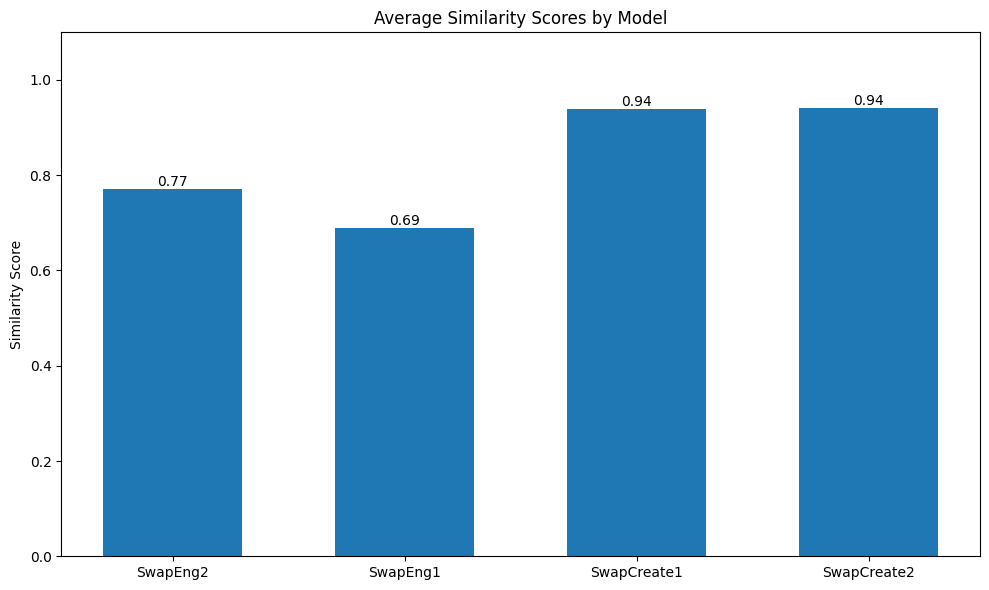

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_simple_similarities(similarities):
    models = list(similarities.keys())

    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(models))

    bars = ax.bar(x, [similarities[m] for m in models], width=0.6)

    ax.set_ylabel('Similarity Score')
    ax.set_title('Average Similarity Scores by Model')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.set_ylim(0, 1.1)

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.2f}',
               ha='center', va='bottom')

    plt.tight_layout()
    return plt

plt = plot_simple_similarities(avg_sims)
plt.savefig('similarity_scores_n.png', dpi=300)
plt.show()

In [15]:
iterations = 50
avg_sims_table = sims_table(iterations)
print(f"Average similarities over {iterations} iterations:")
print(avg_sims_table)

Average similarities over 50 iterations:
{'SwapEng2': {'table_inst_vs_select': 0.6176562875807285, 'table_ctx_vs_select': 0.961646673977375}, 'SwapEng1': {'table_inst_vs_select': 0.6030427317519982, 'table_ctx_vs_select': 0.9444630844394366}, 'SwapCreate1': {'table_inst_vs_select': 0.6792783843775589, 'table_ctx_vs_select': 0.9016348114609718}, 'SwapCreate2': {'table_inst_vs_select': 0.6886975199878215, 'table_ctx_vs_select': 0.8888588929772376}}


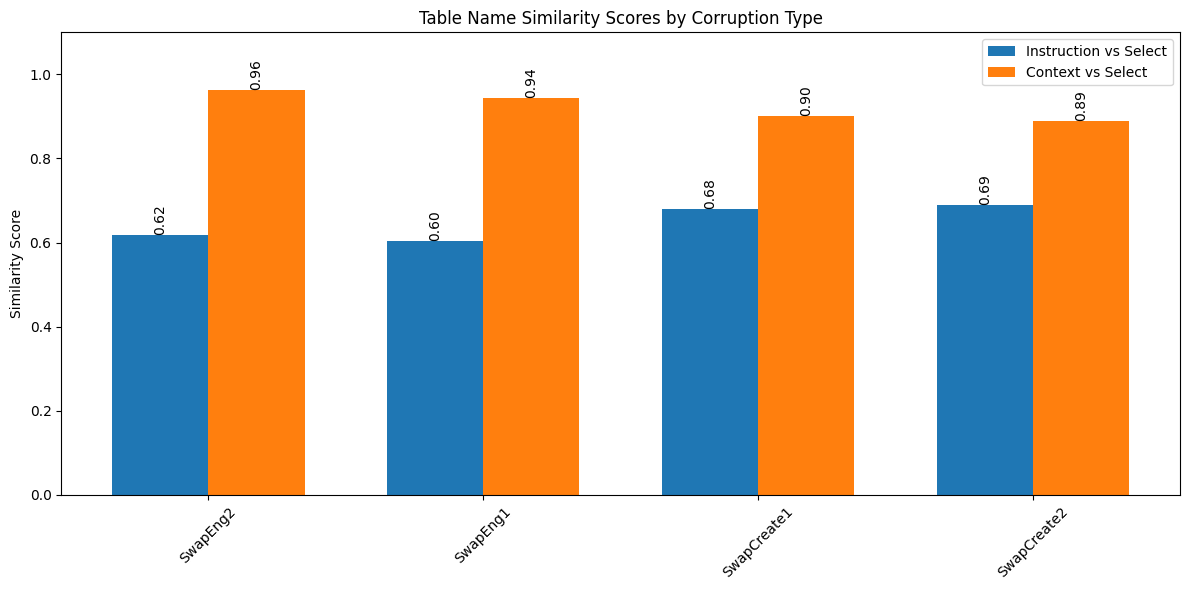

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_table_similarities(similarities):
    models = list(similarities.keys())
    metrics = ['table_inst_vs_select', 'table_ctx_vs_select']

    x = np.arange(len(models))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))

    bars1 = ax.bar(x - width/2,
                   [similarities[m]['table_inst_vs_select'] for m in models],
                   width,
                   label='Instruction vs Select')

    bars2 = ax.bar(x + width/2,
                   [similarities[m]['table_ctx_vs_select'] for m in models],
                   width,
                   label='Context vs Select')

    ax.set_ylabel('Similarity Score')
    ax.set_title('Table Name Similarity Scores by Corruption Type')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45)
    ax.legend()
    ax.set_ylim(0, 1.1)

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2.,
                   height,
                   f'{height:.2f}',
                   ha='center',
                   va='bottom',
                   rotation=90)

    plt.tight_layout()
    return plt

plt = plot_table_similarities(avg_sims_table)
plt.savefig('table_similarity_scores.png', dpi=300)
plt.show()

In [17]:
iterations = 50

model_names = ['SwapEng2', 'SwapEng1', 'SwapCreate1', 'SwapCreate2']  # Can be any names
model_functions = {
    'SwapEng2': swap_field_table_eng_2field,
    'SwapEng1': swap_field_table_eng_1field,
    'SwapCreate1': swap_field_table_create_1field,
    'SwapCreate2': swap_field_table_create_2field
}

avg_sim_field = sims_fields(iterations, model_names, model_functions)
print(f"\nAverage similarities over {iterations} iterations:")
print(avg_sim_field)

Processing:   4%|▍         | 2/50 [00:00<00:11,  4.33it/s]

Error in function SwapEng1: 'NoneType' object is not iterable


Processing:   6%|▌         | 3/50 [00:00<00:10,  4.35it/s]

Error in function SwapEng1: 'NoneType' object is not iterable


Processing:  16%|█▌        | 8/50 [00:01<00:08,  4.86it/s]

Error in function SwapEng1: 'NoneType' object is not iterable


Processing:  20%|██        | 10/50 [00:02<00:09,  4.20it/s]

Error in function SwapEng1: 'NoneType' object is not iterable


Processing:  26%|██▌       | 13/50 [00:03<00:10,  3.48it/s]

Error in function SwapEng1: 'NoneType' object is not iterable


Processing:  34%|███▍      | 17/50 [00:04<00:11,  2.98it/s]

Error in function SwapEng1: 'NoneType' object is not iterable


Processing:  42%|████▏     | 21/50 [00:05<00:07,  3.66it/s]

Error in function SwapEng1: 'NoneType' object is not iterable


Processing:  48%|████▊     | 24/50 [00:06<00:06,  3.88it/s]

Error in function SwapEng1: 'NoneType' object is not iterable


Processing:  52%|█████▏    | 26/50 [00:06<00:06,  3.99it/s]

Error in function SwapEng1: 'NoneType' object is not iterable


Processing:  54%|█████▍    | 27/50 [00:07<00:05,  4.14it/s]

Error in function SwapEng1: 'NoneType' object is not iterable


Processing:  58%|█████▊    | 29/50 [00:07<00:04,  4.33it/s]

Error in function SwapEng1: 'NoneType' object is not iterable


Processing:  60%|██████    | 30/50 [00:07<00:04,  4.16it/s]

Error in function SwapEng1: 'NoneType' object is not iterable


Processing:  62%|██████▏   | 31/50 [00:07<00:04,  4.11it/s]

Error in function SwapEng1: 'NoneType' object is not iterable


Processing:  70%|███████   | 35/50 [00:08<00:03,  4.21it/s]

Error in function SwapEng1: 'NoneType' object is not iterable


Processing:  84%|████████▍ | 42/50 [00:10<00:01,  4.26it/s]

Error in function SwapEng1: 'NoneType' object is not iterable


Processing:  88%|████████▊ | 44/50 [00:11<00:01,  4.05it/s]

Error in function SwapEng1: 'NoneType' object is not iterable



Success Statistics:

SwapEng2:
  Field1_resp_int: 50/50 (100.00%)
  Field1_resp_ctx: 50/50 (100.00%)
  Field2_resp_int: 50/50 (100.00%)
  Field2_resp_ctx: 50/50 (100.00%)

SwapEng1:
  Field1_resp_int: 34/50 (68.00%)
  Field1_resp_ctx: 34/50 (68.00%)
  Field2_resp_int: 34/50 (68.00%)
  Field2_resp_ctx: 34/50 (68.00%)

SwapCreate1:
  Field1_resp_int: 50/50 (100.00%)
  Field1_resp_ctx: 50/50 (100.00%)
  Field2_resp_int: 50/50 (100.00%)
  Field2_resp_ctx: 50/50 (100.00%)

SwapCreate2:
  Field1_resp_int: 50/50 (100.00%)
  Field1_resp_ctx: 50/50 (100.00%)
  Field2_resp_int: 50/50 (100.00%)
  Field2_resp_ctx: 50/50 (100.00%)

Average similarities over 50 iterations:
{'SwapEng2': {'Field1_resp_int': 1.0, 'Field1_resp_ctx': 1.0, 'Field2_resp_int': 0.7687103591230181, 'Field2_resp_ctx': 0.5721617047389348}, 'SwapEng1': {'Field1_resp_int': 0.8908488323875501, 'Field1_resp_ctx': 0.5872249725402571, 'Field2_resp_int': 1.0, 'Field2_resp_ctx': 1.0}, 'SwapCreate1': {'Field1_resp_int': 1.0, 'Field1_re

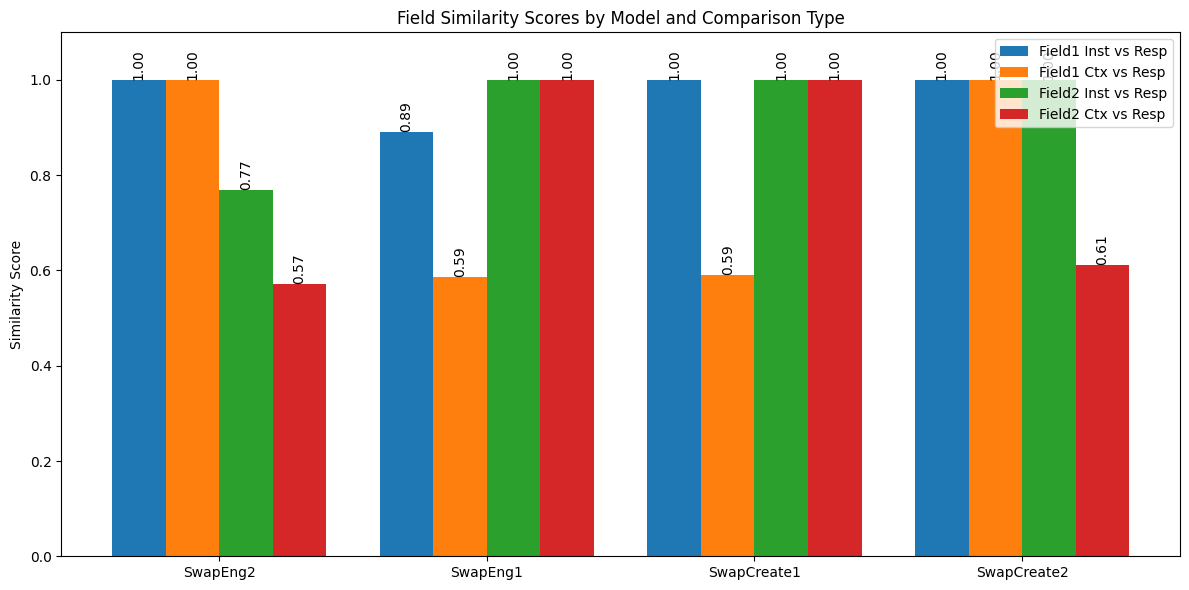

In [18]:
plt = plot_field_similarities(avg_sim_field)
plt.savefig('field_similarity_scores.png', dpi=300)
plt.show()

### Insignificant tokens -> Random words

In [19]:
def replace_sql_words(text):

    instruction_start = text.find('### Instruction:') + len('### Instruction:')
    context_start = text.find('### Context:')
    instruction = text[instruction_start:context_start]

    replacements = {
        'select': 'rose',
        'the': 'hit',
        'and': 'under',
        'from': 'sky',
        'table': 'one'
    }

    new_instruction = instruction
    for old_word, new_word in replacements.items():
        new_instruction = new_instruction.replace(old_word, new_word)

    return text[:instruction_start] + new_instruction + text[context_start:]

In [20]:
base_item = cpt(1)._make_base_item()
base_prompt = base_item.get_alpaca_prompt()
result = replace_sql_words(base_prompt)
print('Base output: ', generate_output(base_prompt, model_sql, tokenizer_sql), '\n')
print('Random replacement output: ', generate_output(result, model_sql, tokenizer_sql))

Base output:  ### Instruction: show me the name and total from the cost table ### Context: CREATE TABLE cost ( name TEXT, total INT ) ### Response: SELECT name, total FROM cost 

Random replacement output:  ### Instruction: show me hit name under total sky hit cost one ### Context: CREATE TABLE cost ( name TEXT, total INT ) ### Response: SELECT name FROM cost


### Corrupt DefTableName, DefFieldName

In [55]:
import re
import random

# List of random words to use as replacements
random_words = [
    'banana', 'rocket', 'pillow', 'guitar', 'sunset',
    'coffee', 'jungle', 'marble', 'circus', 'pepper',
    'cookie', 'puzzle', 'bubble', 'castle', 'dragon',
    'flower', 'mirror', 'ribbon', 'shadow', 'ticket'
]

for word in random_words:
  if is_in_tiny_stories_vocab(word, tokenizer_sql) == False:
    print(word)
    random_words.remove(word)

def replace_field1_instruction(sql_text):
    instruction_text = re.search(r'### Instruction:(.*?)### Context:', sql_text, re.DOTALL)
    if not instruction_text:
        return sql_text

    instruction = instruction_text.group(1).strip()

    # Get first field from instruction
    fields_text = instruction.lower().split('from')[0]
    fields_pattern = r'(?:show|select|get|display)\s+(?:me the\s+)?(\w+)'
    field_match = re.search(fields_pattern, fields_text)
    if not field_match:
        return sql_text

    first_field = field_match.group(1)
    random_word = random.choice(random_words)

    # Replace only in instruction part
    before_context = sql_text.split("### Context:")[0]
    rest_of_text = "### Context:" + "### Context:".join(sql_text.split("### Context:")[1:])

    new_instruction = before_context.replace(first_field, random_word, 1)
    return new_instruction + rest_of_text

def replace_field2_instruction(sql_text):
    instruction_text = re.search(r'### Instruction:(.*?)### Context:', sql_text, re.DOTALL)
    if not instruction_text:
        return sql_text

    instruction = instruction_text.group(1).strip()

    # Get second field from instruction (after 'and')
    fields_pattern = r'and\s+(\w+)'
    field_match = re.search(fields_pattern, instruction.lower())
    if not field_match:
        return sql_text

    second_field = field_match.group(1)
    random_word = random.choice(random_words)

    # Replace only in instruction part
    before_context = sql_text.split("### Context:")[0]
    rest_of_text = "### Context:" + "### Context:".join(sql_text.split("### Context:")[1:])

    new_instruction = before_context.replace(second_field, random_word, 1)
    return new_instruction + rest_of_text

def replace_field1_context(sql_text):
    sections = re.search(r'### Context:(.*?)### Response:', sql_text, re.DOTALL)
    if not sections:
        return sql_text

    context_section = sections.group(1)

    # Get first field from context
    field_pattern = r'\(\s*\n*\s*(\w+)'
    field_match = re.search(field_pattern, context_section)
    if not field_match:
        return sql_text

    first_field = field_match.group(1)
    random_word = random.choice(random_words)

    # Replace only in context part
    new_context = context_section.replace(first_field, random_word, 1)
    before_context = sql_text.split("### Context:")[0]
    after_context = sql_text.split("### Response:")[1]

    return before_context + "### Context:" + new_context + "### Response:" + after_context

def replace_field2_context(sql_text):
    sections = re.search(r'### Context:(.*?)### Response:', sql_text, re.DOTALL)
    if not sections:
        return sql_text

    context_section = sections.group(1)

    # Get second field from context
    field_pattern = r',\s*\n*\s*(\w+)'
    field_match = re.search(field_pattern, context_section)
    if not field_match:
        return sql_text

    second_field = field_match.group(1)
    random_word = random.choice(random_words)

    # Replace only in context part
    new_context = context_section.replace(second_field, random_word, 1)
    before_context = sql_text.split("### Context:")[0]
    after_context = sql_text.split("### Response:")[1]

    return before_context + "### Context:" + new_context + "### Response:" + after_context


banana
pillow
sunset
jungle
circus
puzzle
mirror


In [56]:
iterations = 50

random_names = ['RandomEng2', 'RandomEng1', 'RandomCreate1', 'RandomCreate2']
random_functions = {
    'RandomEng2': swap_field_table_eng_2field,
    'RandomEng1': swap_field_table_eng_1field,
    'RandomCreate1': swap_field_table_create_1field,
    'RandomCreate2': swap_field_table_create_2field
}

avg_sim_field_rd = sims_fields(iterations, random_names, random_functions)

Processing:   6%|▌         | 3/50 [00:01<00:18,  2.57it/s]

Error in function RandomEng1: 'NoneType' object is not iterable


Processing:  16%|█▌        | 8/50 [00:02<00:12,  3.43it/s]

Error in function RandomEng1: 'NoneType' object is not iterable


Processing:  34%|███▍      | 17/50 [00:04<00:07,  4.61it/s]

Error in function RandomEng1: 'NoneType' object is not iterable


Processing:  52%|█████▏    | 26/50 [00:06<00:05,  4.40it/s]

Error in function RandomEng1: 'NoneType' object is not iterable


Processing:  84%|████████▍ | 42/50 [00:11<00:01,  4.15it/s]

Error in function RandomEng1: 'NoneType' object is not iterable


Processing:  92%|█████████▏| 46/50 [00:12<00:00,  4.39it/s]

Error in function RandomEng1: 'NoneType' object is not iterable


Processing:  94%|█████████▍| 47/50 [00:12<00:00,  4.32it/s]

Error in function RandomEng1: 'NoneType' object is not iterable


Processing:  98%|█████████▊| 49/50 [00:12<00:00,  4.39it/s]

Error in function RandomEng1: 'NoneType' object is not iterable



Success Statistics:

RandomEng2:
  Field1_resp_int: 50/50 (100.00%)
  Field1_resp_ctx: 50/50 (100.00%)
  Field2_resp_int: 50/50 (100.00%)
  Field2_resp_ctx: 50/50 (100.00%)

RandomEng1:
  Field1_resp_int: 42/50 (84.00%)
  Field1_resp_ctx: 42/50 (84.00%)
  Field2_resp_int: 42/50 (84.00%)
  Field2_resp_ctx: 42/50 (84.00%)

RandomCreate1:
  Field1_resp_int: 50/50 (100.00%)
  Field1_resp_ctx: 50/50 (100.00%)
  Field2_resp_int: 50/50 (100.00%)
  Field2_resp_ctx: 50/50 (100.00%)

RandomCreate2:
  Field1_resp_int: 50/50 (100.00%)
  Field1_resp_ctx: 50/50 (100.00%)
  Field2_resp_int: 50/50 (100.00%)
  Field2_resp_ctx: 50/50 (100.00%)


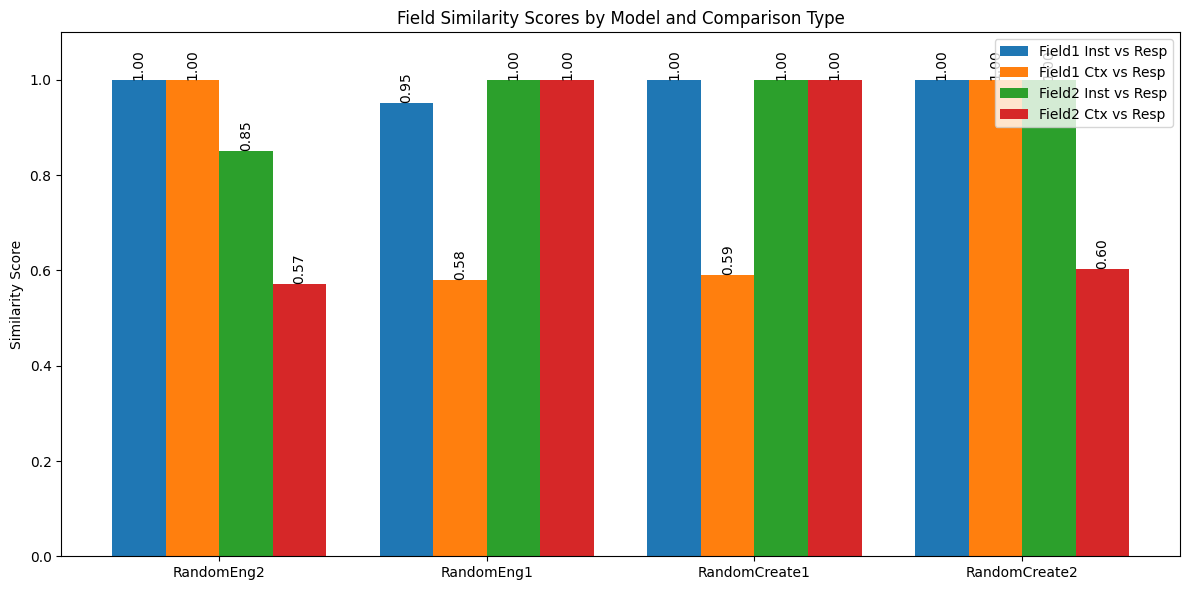

In [155]:
plt = plot_field_similarities(avg_sim_field_rd)
plt.savefig('field_similarity_scores_random.png', dpi=300)
plt.show()

In [150]:
base_item = cpt(1)._make_base_item()
#base_prompt = base_item.get_alpaca_prompt()

result1 = replace_field1_instruction(base_prompt)
result2 = replace_field2_instruction(base_prompt)
result3 = replace_field1_context(base_prompt)
result4 = replace_field2_context(base_prompt)


In [130]:
base_prompt

'### Instruction: show me the id and amount from the inventory table ### Context: CREATE TABLE inventory ( id INT, amount TEXT ) ### Response: '

In [152]:
generate_output(result1, model_sql, tokenizer_sql)

'### Instruction: show me the rocket and amount from the inventory table ### Context: CREATE TABLE inventory ( id INT, amount TEXT ) ### Response: SELECT amount FROM inventory'

In [151]:
generate_output(result2, model_sql, tokenizer_sql)

'### Instruction: show me the id and pepper from the inventory table ### Context: CREATE TABLE inventory ( id INT, amount TEXT ) ### Response: SELECT id, salt FROM inventory'

In [145]:
generate_output(result3, model_sql, tokenizer_sql)

'### Instruction: show me the id and amount from the inventory table ### Context: CREATE TABLE inventory ( ticket INT, amount TEXT ) ### Response: SELECT id, amount FROM inventory'

In [142]:
generate_output(result4, model_sql, tokenizer_sql)

'### Instruction: show me the id and amount from the inventory table ### Context: CREATE TABLE inventory ( id INT, marble TEXT ) ### Response: SELECT id, amount FROM inventory'

In [154]:
generate_output(base_prompt.replace('amount from', 'name from'), model_sql, tokenizer_sql)

'### Instruction: show me the id and name from the inventory table ### Context: CREATE TABLE inventory ( id INT, amount TEXT ) ### Response: SELECT id, name FROM inventory'

In [127]:
generate_output(base_prompt.replace('id CHAR', 'name CHAR'), model_sql, tokenizer_sql)

'### Instruction: show me the color and id from the liquids table ### Context: CREATE TABLE liquids ( color CHAR, name CHAR ) ### Response: SELECT color, id FROM liquids'

In [134]:
result_table = base_prompt.replace('TABLE inventory', 'TABLE customers')
generate_output(result_table, model_sql, tokenizer_sql)

'### Instruction: show me the id and amount from the inventory table ### Context: CREATE TABLE customers ( id INT, amount TEXT ) ### Response: SELECT id, amount FROM customers'

In [ ]:
base_prompt

'### Instruction: show me the amount and count from the orders table ### Context: CREATE TABLE orders ( amount INT, count TIME ) ### Response: '

In [136]:
result_table = base_prompt.replace('inventory table', 'customers table')
generate_output(result_table, model_sql, tokenizer_sql)

'### Instruction: show me the id and amount from the customers table ### Context: CREATE TABLE inventory ( id INT, amount TEXT ) ### Response: SELECT id, amount FROM inventory'

In [80]:
is_in_tiny_stories_vocab('texture', tokenizer_sql)

True

In [54]:
for word in random_words:
  if is_in_tiny_stories_vocab(word, tokenizer_sql) == False:
    print(word)
    random_words.remove(word)

banana
pillow
sunset
jungle
circus
puzzle
mirror


## BM1 CS2

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from TinySQL.load_data.load_model import load_tinysql_model

device = torch.device('cuda')

tokenizer_sql_cs2 = AutoTokenizer.from_pretrained('withmartian/sql_interp_bm1_cs2_experiment_2.7')
tokenizer_sql.pad_token = tokenizer_sql.eos_token

model_sql_cs2 = AutoModelForCausalLM.from_pretrained(
    'withmartian/sql_interp_bm1_cs2_experiment_2.7',
    pad_token_id=tokenizer_sql.eos_token_id
)
model_sql.config.pad_token_id = tokenizer_sql.pad_token_id
model_sql.to(device)

tokenizer_config.json:   0%|          | 0.00/883 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/985 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/315M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50258, 1024)
    (wpe): Embedding(2048, 1024)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-1): 2 x GPTNeoBlock(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=False)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
          (c_proj): L

### My classes

In [ ]:
from dataclasses import dataclass
from typing import List, Optional, Tuple
import random
from TinySQL.training_data.fragments.models import BatchItem, TableField, SelectField
from TinySQL.training_data.sql_create_table import get_sql_create_table_from_selected_fields
from TinySQL.training_data.sql_select_from import get_sql_select_from_selected_fields

UNKNOWN_VALUE = -1

class FeatureTypes:
    """Constants for feature types"""
    ENGTABLENAME = "EngTableName"
    ENGFIELDNAME = "EngFieldName"
    DEFCREATETABLE = "DefCreateTable"
    DEFTABLENAME = "DefTableName"
    DEFFIELDNAME = "DefFieldName"
    DEFFIELDSEPARATOR = "DefFieldSeparator"
    ENGORDERBY = "EngOrderBy"
    ENGORDERBYFIELD = "EngOrderByField"

@dataclass
class CorruptibleBatchItem(BatchItem):
    feature_name: str = ""
    clean_token_str: str = ""  # Clean word
    corrupt_token_str: str = ""  # Corrupted word
    clean_tokenizer_index: int = UNKNOWN_VALUE  # Tokenizer vocab index for clean word
    corrupt_tokenizer_index: int = UNKNOWN_VALUE  # Tokenizer vocab index for corrupted word
    prompt_token_index: int = UNKNOWN_VALUE  # Token index in prompt of clean/corrupt word
    answer_token_index: int = UNKNOWN_VALUE  # Token index in prediction answer of clean/corrupt word
    corrupt_english_prompt: Optional[str] = None
    corrupt_create_statement: Optional[str] = None
    corrupt_sql_statement: Optional[str] = None
    use_corrupt_names: bool = False

    @property
    def clean_BatchItem(self) -> BatchItem:
        return BatchItem(
            command_set=self.command_set,
            table_name=self.table_name,
            table_fields=self.table_fields,
            create_statement=self.create_statement,
            select=self.select,
            order_by=self.order_by,
            english_prompt=self.english_prompt,
            sql_statement=self.sql_statement
        )

    @property
    def corrupt_BatchItem(self) -> BatchItem:
        return BatchItem(
            command_set=self.command_set,
            table_name=self.table_name,
            table_fields=self.table_fields,
            create_statement=self.corrupt_create_statement or self.create_statement,
            select=self.select,
            order_by=self.order_by,
            english_prompt=self.corrupt_english_prompt or self.english_prompt,
            sql_statement=self.corrupt_sql_statement or self.sql_statement
        )

    def print_clean(self):
        full = self.clean_BatchItem.get_alpaca_prompt() + self.clean_BatchItem.sql_statement
        print(f"Clean: Token={self.clean_token_str}, TokenizerIndex={self.clean_tokenizer_index}, "
              f"PromptTokenIndex={self.prompt_token_index}, AnswerTokenIndex={self.answer_token_index}, "
              f"Prompt+Answer={full}")

    def print_corrupt(self):
        full = self.corrupt_BatchItem.get_alpaca_prompt() + self.corrupt_BatchItem.sql_statement
        print(f"Corrupt: Token={self.corrupt_token_str}, TokenizerIndex={self.corrupt_tokenizer_index}, "
              f"PromptTokenIndex={self.prompt_token_index}, AnswerTokenIndex={self.answer_token_index}, "
              f"Prompt+Answer={full}")

    def print_all(self):
        print(f"Feature name: {self.feature_name}")
        if self.feature_name.startswith("Def"):
            print(f"Clean statement: {self.create_statement}")
            print(f"Corrupt statement: {self.corrupt_create_statement}")
        else:
            print(f"Clean prompt: {self.english_prompt}")
            print(f"Corrupt prompt: {self.corrupt_english_prompt}")
        print(f"Use corrupt names: {self.use_corrupt_names}")
        print(f"Clean token: {self.clean_token_str}")
        print(f"Corrupt token: {self.corrupt_token_str}")
        print(f"Prompt token index: {self.prompt_token_index}")
        print(f"Answer token index: {self.answer_token_index}")
        print(f"Clean tokenizer index: {self.clean_tokenizer_index}")
        print(f"Corrupt tokenizer index: {self.corrupt_tokenizer_index}")
        print(self.get_alpaca_prompt())
        print(self.sql_statement)

class CorruptFeatureTestGenerator:
    # Add class-level feature type constants
    ENGTABLENAME = FeatureTypes.ENGTABLENAME
    ENGFIELDNAME = FeatureTypes.ENGFIELDNAME
    DEFCREATETABLE = FeatureTypes.DEFCREATETABLE
    DEFTABLENAME = FeatureTypes.DEFTABLENAME
    DEFFIELDNAME = FeatureTypes.DEFFIELDNAME
    DEFFIELDSEPARATOR = FeatureTypes.DEFFIELDSEPARATOR
    ENGORDERBY = FeatureTypes.ENGORDERBY
    ENGORDERBYFIELD = FeatureTypes.ENGORDERBYFIELD
    def __init__(self, model_num: int = UNKNOWN_VALUE, cs_num: int = UNKNOWN_VALUE,
                 tokenizer = None, use_novel_names: bool = False):
        """Initialize the test generator with model and tokenizer configuration.

        Args:
            model_num: Model identifier number
            cs_num: Command set number
            tokenizer: Tokenizer instance for encoding/decoding tokens
            use_novel_names: Whether to use novel names for corruption
        """
        self.model_num = model_num
        self.cs_num = cs_num
        self.tokenizer = tokenizer
        self.use_corrupt_names = use_novel_names

        # Sample data to generate variations
        self.clean_table_names = ["cost", "people", "inventory", "orders", "products"]
        self.novel_table_names = ["star", "very", "apple", "blue", "orange"]
        self.clean_field_names = ["price", "count", "amount", "total", "name", "id"]
        self.novel_field_names = ["hammer", "little", "wolf", "sky", "yellow"]
        self.clean_field_types = ["INT", "CHAR", "TIME", "TEXT", "JSON"]
        self.order_directions = ["ASC", "DESC"]

    def set_clean_corrupt_tokens(self, item: CorruptibleBatchItem,
                               clean_token: str, corrupt_token: str,
                               in_answer: bool = False) -> None:
        """Set the clean and corrupt token information for a batch item.

        Args:
            item: The batch item to modify
            clean_token: The original clean token
            corrupt_token: The corrupted token
            in_answer: Whether the token appears in the answer (SQL) or prompt
        """
        item.clean_token_str = clean_token
        item.corrupt_token_str = corrupt_token

        if self.tokenizer is not None:
            try:
                item.clean_tokenizer_index = self.tokenizer.encode(clean_token)[0]
                item.corrupt_tokenizer_index = self.tokenizer.encode(corrupt_token)[0]
            except Exception as e:
                print(f"Warning: Failed to encode tokens: {e}")
                item.clean_tokenizer_index = UNKNOWN_VALUE
                item.corrupt_tokenizer_index = UNKNOWN_VALUE

        # Set token indices based on whether it's in the prompt or answer
        if in_answer:
            item.prompt_token_index = UNKNOWN_VALUE
            item.answer_token_index = self._find_token_position(item.sql_statement, clean_token)
        else:
            item.prompt_token_index = self._find_token_position(
                item.english_prompt if not item.feature_name.startswith("Def")
                else item.create_statement,
                clean_token
            )
            item.answer_token_index = UNKNOWN_VALUE

    def _find_token_position(self, text: str, token: str) -> int:
        """Find the position of a token in text.

        Args:
            text: The text to search in
            token: The token to find

        Returns:
            The position of the token or UNKNOWN_VALUE if not found
        """
        try:
            if self.tokenizer is not None:
                tokens = self.tokenizer.encode(text)
                token_id = self.tokenizer.encode(token)[0]
                return tokens.index(token_id)
        except:
            pass
        return UNKNOWN_VALUE

    def _make_base_item(self, include_order_by: bool = False) -> BatchItem:
        """Create a random clean base item with optional ORDER BY"""
        table_name = random.choice(self.clean_table_names)
        fields = random.sample(self.clean_field_names, 2)
        types = [random.choice(self.clean_field_types) for _ in fields]

        assert fields[0] != fields[1]
        selected_fields = [TableField(f, t) for f, t in zip(fields, types)]

        # Base SQL and English parts
        base_english = f"show me the {fields[0]} and {fields[1]} from the {table_name} table"
        base_sql = get_sql_select_from_selected_fields(table_name, selected_fields)[1]

        order_by_fields = []
        if include_order_by:
            order_field = random.choice(fields)
            direction = random.choice(self.order_directions)
            order_by_fields = [SelectField(order_field, direction)]

            base_english += f" ordered by {order_field}"
            base_sql += f" ORDER BY {order_field} {direction}"  # Changed \n to space

        return BatchItem(
            command_set=2 if include_order_by else 1,
            table_name=table_name,
            table_fields=selected_fields,
            create_statement=get_sql_create_table_from_selected_fields(table_name, selected_fields)[2],
            select=[SelectField(f, "") for f in fields],
            order_by=order_by_fields,
            english_prompt=base_english,
            sql_statement=base_sql,
        )

    def _corrupt_eng_order_by(self) -> CorruptibleBatchItem:
        """Corrupts the ORDER BY keyword in English prompt"""
        base = self._make_base_item(include_order_by=True)
        wrong_orders = ["sorted by", "grouped by", "arranged by", "classified by"]
        wrong_order = random.choice(wrong_orders)
        corrupted = base.english_prompt.replace("ordered by", wrong_order)

        item = CorruptibleBatchItem(
            **vars(base),
            feature_name=ENGORDERBY,
            corrupt_english_prompt=corrupted
        )
        self.set_clean_corrupt_tokens(item, "ordered by", wrong_order, False)
        return item

    def _corrupt_eng_table_name(self) -> CorruptibleBatchItem:
        """Corrupts the table name in the English prompt"""
        base = self._make_base_item(include_order_by=False)
        original_table = base.table_name

        # Choose a table name that's not the current one
        names = self.novel_table_names if self.use_corrupt_names else self.clean_table_names
        wrong_table = random.choice([t for t in names if t != original_table])

        corrupted = base.english_prompt.replace(
            f"from the {original_table} table",
            f"from the {wrong_table} table"
        )

        item = CorruptibleBatchItem(
            **vars(base),
            feature_name=FeatureTypes.ENGTABLENAME,
            corrupt_english_prompt=corrupted
        )
        self.set_clean_corrupt_tokens(item, original_table, wrong_table, False)
        return item

    def _corrupt_eng_field_name(self) -> CorruptibleBatchItem:
        """Corrupts a field name in the English prompt"""
        base = self._make_base_item(include_order_by=False)
        fields = [f.name for f in base.table_fields]
        original_field = random.choice(fields)

        # Choose a field name that's not in the current fields
        names = self.novel_field_names if self.use_corrupt_names else self.clean_field_names
        wrong_field = random.choice([f for f in names if f not in fields])

        corrupted = base.english_prompt.replace(original_field, wrong_field)

        item = CorruptibleBatchItem(
            **vars(base),
            feature_name=FeatureTypes.ENGFIELDNAME,
            corrupt_english_prompt=corrupted
        )
        self.set_clean_corrupt_tokens(item, original_field, wrong_field, False)
        return item

    def _corrupt_def_create_table(self) -> CorruptibleBatchItem:
        """Corrupts the CREATE TABLE statement by changing the keyword"""
        base = self._make_base_item(include_order_by=False)
        wrong_keywords = ["MAKE TABLE", "BUILD TABLE", "CONSTRUCT TABLE", "GENERATE TABLE"]
        wrong_keyword = random.choice(wrong_keywords)

        corrupted = base.create_statement.replace("CREATE TABLE", wrong_keyword)

        item = CorruptibleBatchItem(
            **vars(base),
            feature_name=FeatureTypes.DEFCREATETABLE,
            corrupt_create_statement=corrupted
        )
        self.set_clean_corrupt_tokens(item, "CREATE TABLE", wrong_keyword, True)
        return item

    def _corrupt_def_table_name(self) -> CorruptibleBatchItem:
        """Corrupts the table name in the CREATE TABLE statement"""
        base = self._make_base_item(include_order_by=False)
        original_table = base.table_name

        names = self.novel_table_names if self.use_corrupt_names else self.clean_table_names
        wrong_table = random.choice([t for t in names if t != original_table])

        corrupted = base.create_statement.replace(
            f"CREATE TABLE {original_table}",
            f"CREATE TABLE {wrong_table}"
        )

        item = CorruptibleBatchItem(
            **vars(base),
            feature_name=FeatureTypes.DEFTABLENAME,
            corrupt_create_statement=corrupted
        )
        self.set_clean_corrupt_tokens(item, original_table, wrong_table, True)
        return item

    def _corrupt_def_field_name(self) -> CorruptibleBatchItem:
        """Corrupts a field name in the CREATE TABLE statement"""
        base = self._make_base_item(include_order_by=False)
        fields = [f.name for f in base.table_fields]
        original_field = random.choice(fields)

        names = self.novel_field_names if self.use_corrupt_names else self.clean_field_names
        wrong_field = random.choice([f for f in names if f not in fields])

        corrupted = base.create_statement.replace(
            f"{original_field} ",
            f"{wrong_field} "
        )

        item = CorruptibleBatchItem(
            **vars(base),
            feature_name=FeatureTypes.DEFFIELDNAME,
            corrupt_create_statement=corrupted
        )
        self.set_clean_corrupt_tokens(item, original_field, wrong_field, True)
        return item

    def _corrupt_def_field_separator(self) -> CorruptibleBatchItem:
        """Corrupts the field separator in the CREATE TABLE statement"""
        base = self._make_base_item(include_order_by=False)
        wrong_separators = [";", ":", "&", "|"]
        wrong_separator = random.choice(wrong_separators)

        corrupted = base.create_statement.replace(",", wrong_separator)

        item = CorruptibleBatchItem(
            **vars(base),
            feature_name=FeatureTypes.DEFFIELDSEPARATOR,
            corrupt_create_statement=corrupted
        )
        self.set_clean_corrupt_tokens(item, ",", wrong_separator, True)
        return item

    def _corrupt_eng_order_by_field(self) -> CorruptibleBatchItem:
        """Corrupts the field name in ORDER BY clause"""
        base = self._make_base_item(include_order_by=True)
        original_order_field = base.order_by[0].name

        base_fields = [field.name for field in base.table_fields]
        names = self.novel_field_names if self.use_corrupt_names else self.clean_field_names
        wrong_field = random.choice([f for f in names if f not in base_fields])

        corrupted = base.english_prompt.replace(
            f"ordered by {original_order_field}",
            f"ordered by {wrong_field}"
        )

        item = CorruptibleBatchItem(
            **vars(base),
            feature_name=FeatureTypes.ENGORDERBYFIELD,
            corrupt_english_prompt=corrupted
        )
        self.set_clean_corrupt_tokens(item, original_order_field, wrong_field, False)
        return item

    def get_generators(self) -> dict:
        """Return all the corruption generators"""
        return {
            FeatureTypes.ENGTABLENAME: self._corrupt_eng_table_name,
            FeatureTypes.ENGFIELDNAME: self._corrupt_eng_field_name,
            FeatureTypes.DEFCREATETABLE: self._corrupt_def_create_table,
            FeatureTypes.DEFTABLENAME: self._corrupt_def_table_name,
            FeatureTypes.DEFFIELDSEPARATOR: self._corrupt_def_field_separator,
            FeatureTypes.DEFFIELDNAME: self._corrupt_def_field_name,
            FeatureTypes.ENGORDERBY: self._corrupt_eng_order_by,
            FeatureTypes.ENGORDERBYFIELD: self._corrupt_eng_order_by_field
        }

    def generate_feature_examples(self, feature_name: str, batch_size: int = 5) -> List[CorruptibleBatchItem]:

        generators = self.get_generators()

        if feature_name not in generators:
            raise ValueError(f"Unknown feature: {feature_name}")

        return [generators[feature_name]() for _ in range(batch_size)]

### Rest of the code

In [ ]:
generator = CorruptFeatureTestGenerator()
base_item = generator._make_base_item(include_order_by=True)
order_by_corrupted = generator.generate_feature_examples(generator.ENGORDERBY)

In [ ]:
base_prompt

'### Instruction: show me the count and id from the people table ordered by count ### Context: CREATE TABLE people ( count JSON, id TEXT ) ### Response: '

In [ ]:
base_prompt = base_item.get_alpaca_prompt()
base_output = generate_output(base_prompt, model_sql_cs2, tokenizer_sql_cs2)
base_output

'### Instruction: show me the count and id from the people table ordered by count ### Context: CREATE TABLE people ( count JSON, id TEXT ) ### Response: \n    id SERIAL,\n \n count,\n\n '